## Import Library

---

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.4 MB/s eta 0:00:00


In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import torch
import torchvision
import timm
import copy
from PIL import Image
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torch import nn, optim
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
start = time.time()

## Dataset Cervical Cancer

In [ ]:
!git clone https://github.com/dunasi4139/Cervical-Cancer-EfficientNetV2.git

Cloning into 'Cervical-Cancer-EfficientNetV2'...
remote: Enumerating objects: 5018, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 5018 (delta 1), reused 10 (delta 1), pack-reused 5008
Receiving objects: 100% (5018/5018), 223.52 MiB | 16.55 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (5004/5004), done.


In [ ]:
base_dir = '/content/Cervical-Cancer-EfficientNetV2/dataset'
data_dir = os.path.join(base_dir)

In [ ]:
os.listdir(data_dir)

['cervix_dyk', 'cervix_pab', 'cervix_mep', 'cervix_koc', 'cervix_sfi']

In [ ]:
def get_data_loaders(data_dir, batch_size):
    transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize((0.488), (0.2172))
    ])
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    train_data_len = int(len(dataset)*0.6)
    valid_data_len = int((len(dataset) - train_data_len)/2)
    test_data_len = int(len(dataset) - train_data_len - valid_data_len)
    train_data, val_data, test_data = random_split(dataset, [train_data_len, valid_data_len, test_data_len])
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)

    return (train_loader, val_loader, test_loader, train_data_len, valid_data_len, test_data_len, dataset)

In [ ]:
def get_classes(data_dir):
    dataset = datasets.ImageFolder(data_dir)
    return dataset.classes

In [ ]:
(train_loader, val_loader, test_loader, train_data_len, valid_data_len, test_data_len, dataset) = get_data_loaders(data_dir, 64)
classes = get_classes(data_dir)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
my_dataloaders = {
    "train":train_loader,
    "val": val_loader
}
my_dataset_sizes = {
    "train":train_data_len,
    "val": valid_data_len
}

In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))
print(train_data_len, test_data_len, valid_data_len)

47
16
16
3000 1000 1000


In [ ]:
torch.backends.cudnn.benchmark = True

## Perancangan Model Arsitektur EfficientNetV2

In [ ]:
KONFIGURASI_PARAMS = {
    "b0": {
        "widths": [32, 16, 32, 48, 96, 112, 192],
        "depths": [1, 2, 2, 3, 5, 8],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
        "timm_weights": "tf_efficientnetv2_b0",
    },
    "b1": {
        "widths": [32, 16, 32, 48, 96, 112, 192],
        "depths": [2, 3, 3, 4, 6, 9],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs":[0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
        "timm_weights":"tf_efficientnetv2_b1",
    },
    "b2": {
        "widths": [32, 16, 32, 56, 104, 120, 208],
        "depths": [2, 3, 3, 4, 6, 10],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1408,
        "timm_weights":"tf_efficientnetv2_b2",
    },
    "small": {
        "widths": [24, 24, 48, 64, 128, 160, 256],
        "depths": [2, 4, 4, 6, 9, 15],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
        "timm_weights": "tf_efficientnetv2_s"
    },
    "med": {
        "widths": [24, 24, 48, 80, 160, 176, 304, 512],
        "depths": [3, 5, 5, 7, 14, 18, 5],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "convs": [0, 1, 1, 2, 3, 3, 3],
        "output_conv_size": 1280,
        "timm_weights":"tf_efficientnetv2_m",
    },
    "large": {
        "widths": [32, 32, 64, 96, 192, 224, 384, 640],
        "depths": [4, 7, 7, 10, 19, 25, 7],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "convs": [0, 1, 1, 2, 3, 3, 3],
        "output_conv_size": 1280,
        "timm_weights":"tf_efficientnetv2_l",
    }
}

In [ ]:
def conv_block(in_channels, out_channels, kernel_size=3,
               stride=1, padding=1, groups=1,
               bias=False, bn=True, act = True):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride,
                  padding=padding, groups=groups, bias=bias),
        nn.BatchNorm2d(out_channels) if bn else nn.Identity(),
        nn.SiLU() if act else nn.Identity()
    ]
    return nn.Sequential(*layers)

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, c, r=24):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveMaxPool2d(1)
        self.excitation = nn.Sequential(
            nn.Conv2d(c, c // r, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(c // r, c, kernel_size=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        s = self.squeeze(x)
        e = self.excitation(s)
        return x * e

In [ ]:
class MBConv(nn.Module):
    def __init__(self, n_in, n_out, expansion, kernel_size=3, stride=1, r=24, dropout=0.1):
        super(MBConv, self).__init__()
        self.skip_connection = (n_in == n_out) and (stride == 1)

        padding = (kernel_size-1)//2
        expanded = expansion*n_in

        self.expand_pw = nn.Identity() if expansion == 1 else conv_block(n_in, expanded, kernel_size=1, padding=0)
        self.depthwise = conv_block(expanded, expanded, kernel_size=kernel_size,
                                    stride=stride, padding=padding, groups=expanded)
        self.se = SEBlock(expanded, r=4 * expansion)
        self.reduce_pw = conv_block(expanded, n_out, kernel_size=1, padding=0, act=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.expand_pw(x)
        x = self.depthwise(x)
        x = self.se(x)
        x = self.reduce_pw(x)
        if self.skip_connection:
            x = self.dropout(x)
            x = x + residual
        return x

In [ ]:
class FusedMBConv(nn.Module):
    def __init__(self, n_in, n_out, expansion, kernel_size=3, stride=1, r=24, dropout=0.1):
        super(FusedMBConv, self).__init__()
        self.skip_connection = (n_in == n_out) and (stride == 1)
        padding = (kernel_size-1)//2
        expanded = expansion*n_in

        self.expand_pw = conv_block(n_in, expanded, kernel_size=3, stride=stride, padding=1)
        self.reduce_pw = conv_block(expanded, n_out, kernel_size=1, padding=0, act=False)

        if expansion == 1:
            self.reduce_pw = nn.Identity()
            self.expand_pw = conv_block(n_in, n_out, kernel_size=3, stride=stride, padding=1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.expand_pw(x)
        x = self.reduce_pw(x)
        if self.skip_connection:
            x = self.dropout(x)
            x = x + residual
        return x

In [ ]:
def mbconv4(n_in, n_out, kernel_size=3, stride=1, r=24, dropout=0.1):
    return MBConv(n_in, n_out, 4, kernel_size=kernel_size, stride=stride, r=r, dropout=dropout)
def mbconv6(n_in, n_out, kernel_size=3, stride=1, r=24, dropout=0.1):
    return MBConv(n_in, n_out, 6, kernel_size=kernel_size, stride=stride, r=r, dropout=dropout)
def fused_mbconv1(n_in, n_out, kernel_size=3, stride=1, r=24, dropout=0.1):
    return FusedMBConv(n_in, n_out, 1, kernel_size=kernel_size, stride=stride, r=r, dropout=dropout)
def fused_mbconv4(n_in, n_out, kernel_size=3, stride=1, r=24, dropout=0.1):
    return FusedMBConv(n_in, n_out, 4, kernel_size=kernel_size, stride=stride, r=r, dropout=dropout)
layers_map = [fused_mbconv1, fused_mbconv4, mbconv4, mbconv6]

In [ ]:
def create_stage(n_in, n_out, num_layers, layer=mbconv6,
                 kernel_size=3, stride=1, r=24, ps=0):
    layers = [layer(n_in, n_out, kernel_size=kernel_size,
                       stride=stride, r=r, dropout=ps)]
    layers += [layer(n_out, n_out, kernel_size=kernel_size,
                        r=r, dropout=ps) for _ in range(num_layers-1)]
    return nn.Sequential(*layers)

In [ ]:
class EfficientNetV2(nn.Module):
    def __init__(self, cfg, n_classes=1000):
        super(EfficientNetV2, self).__init__()
        self.cfg = cfg
        self.n_classes = n_classes
        widths, depths, strides, convs = cfg['widths'],cfg['depths'],cfg['strides'],cfg['convs']
        outconv_size = cfg['output_conv_size']

        stages = [conv_block(3, widths[0], stride=2, padding=1)]
        for i in range(len(depths)):
            stages.append(create_stage(widths[i], widths[i + 1], depths[i], layer=layers_map[convs[i]],
                        stride=strides[i], r=4 if i ==0 else 24, ps=0))

        self.features = nn.Sequential(*stages)
        self.pre = conv_block(widths[-1], outconv_size, kernel_size=1, padding=0)
        self.pool_flatten = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten())
        self.head = nn.Sequential(
            nn.Linear(outconv_size, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pre(x)
        x = self.pool_flatten(x)
        x = self.head(x)
        return x

In [ ]:
def efficientnetv2_b0(n_classes=1000):
    return EfficientNetV2(KONFIGURASI_PARAMS['b0'], n_classes=n_classes)
def efficientnetv2_b1(n_classes=1000):
    return EfficientNetV2(KONFIGURASI_PARAMS['b1'], n_classes=n_classes)
def efficientnetv2_b2(n_classes=1000):
    return EfficientNetV2(KONFIGURASI_PARAMS['b2'], n_classes=n_classes)
def efficientnetv2_small(n_classes=1000):
    return EfficientNetV2(KONFIGURASI_PARAMS['small'], n_classes=n_classes)
def efficientnetv2_med(n_classes=1000):
    return EfficientNetV2(KONFIGURASI_PARAMS['med'], n_classes=n_classes)
def efficientnetv2_large(n_classes=1000):
    return EfficientNetV2(KONFIGURASI_PARAMS['large'], n_classes=n_classes)

In [ ]:
def load_timm_weights(model):
    url = model.cfg.get("timm_weights")
    timm_model = timm.create_model(url, pretrained=True, num_classes=len(classes))
    params = nn.utils.parameters_to_vector(timm_model.parameters())
    nn.utils.vector_to_parameters(params, model.parameters())

In [ ]:
model = efficientnetv2_med(n_classes=len(classes))
load_timm_weights(model)

In [ ]:
# def print_size_of_model(model):
#     torch.save(model.state_dict(), "temp.p")
#     print('Size (MB):', os.path.getsize("temp.p")/1e6)
#     os.remove('temp.p')

In [ ]:
# print_size_of_model(model)

## Training Data

### Function

In [ ]:
my_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_model = model.to(my_device)
my_device

device(type='cuda', index=0)

In [ ]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(my_device)
optimizer = optim.AdamW(model.head.parameters(), lr=0.001)

In [ ]:
my_training_history = {'akurasi':[],'loss':[]}
my_validation_history = {'akurasi':[],'loss':[]}

In [ ]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [ ]:
def training_model(my_model, my_criterion, my_optimizer, my_scheduler, my_num_epochs=25):
    best_model_wts = copy.deepcopy(my_model.state_dict())
    akurasi_terbaik = 0.0
    epoch_terbaik = 0
    loss_terbaik = 0

    for my_epoch in range(my_num_epochs):
        print('Epoch {}/{}'.format(my_epoch+1, my_num_epochs))
        print('_' * 50)

        for my_phase in ['train', 'val']:
            if my_phase == 'train':
                my_model.train()
            else:
                my_model.eval()

            running_loss = 0.0
            running_corrects = 0

            for my_inputs, my_labels in tqdm(my_dataloaders[my_phase]):
                my_inputs = my_inputs.to(my_device)
                my_labels = my_labels.to(my_device)

                my_optimizer.zero_grad()

                with torch.set_grad_enabled(my_phase == 'train'):
                    my_outputs = my_model(my_inputs)
                    _, my_preds = torch.max(my_outputs, 1)
                    my_loss = my_criterion(my_outputs, my_labels)

                    if my_phase == 'train':
                        my_loss.backward()
                        my_optimizer.step()

                running_loss += my_loss.item() * my_inputs.size(0)
                running_corrects += torch.sum(my_preds == my_labels.data)
            if my_phase == 'train':
                my_scheduler.step()

            epoch_loss = running_loss / my_dataset_sizes[my_phase]
            epoch_akurasi = running_corrects.double() / my_dataset_sizes[my_phase]

            if my_phase == 'train':
                my_training_history['akurasi'].append(epoch_akurasi)
                my_training_history['loss'].append(epoch_loss)
            elif my_phase == 'val':
                my_validation_history['akurasi'].append(epoch_akurasi)
                my_validation_history['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Akurasi: {:.4f}'.format(
                my_phase, epoch_loss, epoch_akurasi))

            if my_phase == 'val' and epoch_akurasi > akurasi_terbaik:
                akurasi_terbaik = epoch_akurasi
                loss_terbaik = epoch_loss
                epoch_terbaik = my_epoch+1
                best_model_wts = copy.deepcopy(my_model.state_dict())

        print()

    print('Akurasi Terbaik: {:4f}'.format(akurasi_terbaik))
    print('Loss Terbaik: {:4f}'.format(loss_terbaik))
    print('Epoch Terbaik: {:4f}'.format(epoch_terbaik))

    my_model.load_state_dict(best_model_wts)
    return my_model, my_training_history, my_validation_history

In [ ]:
for param in my_model.parameters():
    param.requires_grad = True
optimizer = optim.AdamW(my_model.parameters(), lr=0.00015)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

### Hasil

In [ ]:
my_model_at, my_training_history, my_validation_history = training_model(my_model, criterion, optimizer, exp_lr_scheduler,
                       my_num_epochs=30)

Epoch 1/30
__________________________________________________


100%|██████████| 47/47 [00:50<00:00,  1.08s/it]


train Loss: 1.0407 Akurasi: 0.7587


100%|██████████| 16/16 [00:09<00:00,  1.68it/s]


val Loss: 3.3644 Akurasi: 0.5840

Epoch 2/30
__________________________________________________


100%|██████████| 47/47 [00:36<00:00,  1.29it/s]


train Loss: 0.1738 Akurasi: 0.9380


100%|██████████| 16/16 [00:08<00:00,  1.90it/s]


val Loss: 0.1692 Akurasi: 0.9420

Epoch 3/30
__________________________________________________


100%|██████████| 47/47 [00:35<00:00,  1.32it/s]


train Loss: 0.0887 Akurasi: 0.9697


100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


val Loss: 0.1210 Akurasi: 0.9600

Epoch 4/30
__________________________________________________


100%|██████████| 47/47 [00:36<00:00,  1.27it/s]


train Loss: 0.0582 Akurasi: 0.9790


100%|██████████| 16/16 [00:09<00:00,  1.77it/s]


val Loss: 0.1441 Akurasi: 0.9450

Epoch 5/30
__________________________________________________


100%|██████████| 47/47 [00:35<00:00,  1.31it/s]


train Loss: 0.0341 Akurasi: 0.9907


100%|██████████| 16/16 [00:07<00:00,  2.05it/s]


val Loss: 0.0739 Akurasi: 0.9740

Epoch 6/30
__________________________________________________


100%|██████████| 47/47 [00:35<00:00,  1.31it/s]


train Loss: 0.0273 Akurasi: 0.9903


100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


val Loss: 0.0405 Akurasi: 0.9820

Epoch 7/30
__________________________________________________


100%|██████████| 47/47 [00:36<00:00,  1.30it/s]


train Loss: 0.0182 Akurasi: 0.9937


100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


val Loss: 0.0663 Akurasi: 0.9780

Epoch 8/30
__________________________________________________


100%|██████████| 47/47 [00:35<00:00,  1.31it/s]


train Loss: 0.0222 Akurasi: 0.9943


100%|██████████| 16/16 [00:07<00:00,  2.04it/s]


val Loss: 0.0296 Akurasi: 0.9920

Epoch 9/30
__________________________________________________


100%|██████████| 47/47 [00:36<00:00,  1.30it/s]


train Loss: 0.0087 Akurasi: 0.9970


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


val Loss: 0.0456 Akurasi: 0.9870

Epoch 10/30
__________________________________________________


100%|██████████| 47/47 [00:35<00:00,  1.31it/s]


train Loss: 0.0087 Akurasi: 0.9980


100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


val Loss: 0.0441 Akurasi: 0.9860

Epoch 11/30
__________________________________________________


100%|██████████| 47/47 [00:35<00:00,  1.31it/s]


train Loss: 0.0080 Akurasi: 0.9977


100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


val Loss: 0.0313 Akurasi: 0.9890

Epoch 12/30
__________________________________________________


100%|██████████| 47/47 [00:35<00:00,  1.31it/s]


train Loss: 0.0072 Akurasi: 0.9980


100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


val Loss: 0.0275 Akurasi: 0.9920

Epoch 13/30
__________________________________________________


100%|██████████| 47/47 [00:36<00:00,  1.30it/s]


train Loss: 0.0060 Akurasi: 0.9980


100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


val Loss: 0.0442 Akurasi: 0.9880

Epoch 14/30
__________________________________________________


100%|██████████| 47/47 [00:36<00:00,  1.30it/s]


train Loss: 0.0107 Akurasi: 0.9963


100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


val Loss: 0.0391 Akurasi: 0.9880

Epoch 15/30
__________________________________________________


100%|██████████| 47/47 [00:36<00:00,  1.29it/s]


train Loss: 0.0091 Akurasi: 0.9970


100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


val Loss: 0.0271 Akurasi: 0.9890

Epoch 16/30
__________________________________________________


100%|██████████| 47/47 [00:36<00:00,  1.29it/s]


train Loss: 0.0046 Akurasi: 0.9983


100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


val Loss: 0.0363 Akurasi: 0.9870

Epoch 17/30
__________________________________________________


100%|██████████| 47/47 [00:36<00:00,  1.30it/s]


train Loss: 0.0068 Akurasi: 0.9980


100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


val Loss: 0.0244 Akurasi: 0.9920

Epoch 18/30
__________________________________________________


100%|██████████| 47/47 [00:37<00:00,  1.27it/s]


train Loss: 0.0069 Akurasi: 0.9983


100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


val Loss: 0.0201 Akurasi: 0.9920

Epoch 19/30
__________________________________________________


100%|██████████| 47/47 [00:35<00:00,  1.32it/s]


train Loss: 0.0108 Akurasi: 0.9970


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


val Loss: 0.0365 Akurasi: 0.9880

Epoch 20/30
__________________________________________________


100%|██████████| 47/47 [00:36<00:00,  1.30it/s]


train Loss: 0.0136 Akurasi: 0.9957


100%|██████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.0276 Akurasi: 0.9910

Epoch 21/30
__________________________________________________


100%|██████████| 47/47 [00:36<00:00,  1.28it/s]


train Loss: 0.0035 Akurasi: 0.9987


100%|██████████| 16/16 [00:09<00:00,  1.74it/s]


val Loss: 0.0238 Akurasi: 0.9910

Epoch 22/30
__________________________________________________


100%|██████████| 47/47 [00:35<00:00,  1.31it/s]


train Loss: 0.0013 Akurasi: 0.9997


100%|██████████| 16/16 [00:07<00:00,  2.04it/s]


val Loss: 0.0261 Akurasi: 0.9940

Epoch 23/30
__________________________________________________


100%|██████████| 47/47 [00:36<00:00,  1.28it/s]


train Loss: 0.0016 Akurasi: 1.0000


100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


val Loss: 0.0280 Akurasi: 0.9930

Epoch 24/30
__________________________________________________


100%|██████████| 47/47 [00:35<00:00,  1.31it/s]


train Loss: 0.0038 Akurasi: 0.9987


100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


val Loss: 0.0154 Akurasi: 0.9960

Epoch 25/30
__________________________________________________


100%|██████████| 47/47 [00:35<00:00,  1.31it/s]


train Loss: 0.0017 Akurasi: 0.9993


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


val Loss: 0.0190 Akurasi: 0.9930

Epoch 26/30
__________________________________________________


100%|██████████| 47/47 [00:37<00:00,  1.27it/s]


train Loss: 0.0015 Akurasi: 0.9993


100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


val Loss: 0.0213 Akurasi: 0.9940

Epoch 27/30
__________________________________________________


100%|██████████| 47/47 [00:36<00:00,  1.30it/s]


train Loss: 0.0026 Akurasi: 0.9993


100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.0093 Akurasi: 0.9980

Epoch 28/30
__________________________________________________


100%|██████████| 47/47 [00:36<00:00,  1.29it/s]


train Loss: 0.0049 Akurasi: 0.9987


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


val Loss: 0.0247 Akurasi: 0.9970

Epoch 29/30
__________________________________________________


100%|██████████| 47/47 [00:35<00:00,  1.31it/s]


train Loss: 0.0016 Akurasi: 1.0000


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


val Loss: 0.0120 Akurasi: 0.9950

Epoch 30/30
__________________________________________________


100%|██████████| 47/47 [00:35<00:00,  1.31it/s]


train Loss: 0.0014 Akurasi: 0.9997


100%|██████████| 16/16 [00:07<00:00,  2.06it/s]

val Loss: 0.0102 Akurasi: 0.9980

Akurasi Terbaik: 0.998000
Loss Terbaik: 0.009320
Epoch Terbaik: 27.000000


## Testing Data

### Function

In [ ]:
def testing_model(my_model):
  test_loss = 0.0
  kelas_correct = list(0. for i in range(len(classes)))
  kelas_total = list(0. for i in range(len(classes)))

  my_model.eval()

  for data, target in tqdm(test_loader):
      if torch.cuda.is_available():
          data, target = data.cuda(), target.cuda()
      with torch.no_grad():
        output = my_model(data)
        loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, prediksi = torch.max(output, 1)
      correct_ts = prediksi.eq(target.data.view_as(prediksi))
      correct = np.squeeze(correct_ts.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_ts.cpu().numpy())
      if len(target) == 64:
        for i in range(64):
            label = target.data[i]
            kelas_correct[label] += correct[i].item()
            kelas_total[label] += 1

  test_loss = test_loss/len(test_loader.dataset)
  print('Testing Model Loss : {:.6f}\n'.format(test_loss))

  for i in range(len(classes)):
      if kelas_total[i] > 0:
          print('Akurasi Testing Model dari %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * kelas_correct[i] / kelas_total[i],
              np.sum(kelas_correct[i]), np.sum(kelas_total[i])))
      else:
          print('Akurasi Testing Model dari %5s: Tidak Ada (tidak ada contoh latihan)' % (classes[i]))

  print('\nAkurasi Testing Model Total (Secara Keseluruhan): {:.4f} ({}/{})'.format(
      100. * np.sum(kelas_correct) / np.sum(kelas_total),
      np.sum(kelas_correct), np.sum(kelas_total)))


### Hasil

In [ ]:
testing_model(my_model_at)

100%|██████████| 16/16 [00:08<00:00,  1.82it/s]

Testing Model Loss : 0.027575

Akurasi Testing Model dari cervix_dyk: 99% (197/198)
Akurasi Testing Model dari cervix_koc: 99% (185/186)
Akurasi Testing Model dari cervix_mep: 97% (189/193)
Akurasi Testing Model dari cervix_pab: 100% (193/193)
Akurasi Testing Model dari cervix_sfi: 100% (190/190)

Akurasi Testing Model Total (Secara Keseluruhan): 99.3750 (954.0/960.0)


## Prediksi Gambar

### Function

In [ ]:
def prediksi_gambar(my_model, pred_path):
    transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize((0.488), (0.2172))
    ])

    prediksi_gambar = Image.open(pred_path).convert("RGB")
    prediksi_gambar = transform(prediksi_gambar)
    prediksi_gambar = prediksi_gambar.unsqueeze(0)

    my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    my_model = my_model.to(my_device)
    prediksi_gambar = prediksi_gambar.to(my_device)

    my_model.eval()
    with torch.no_grad():
        output = my_model(prediksi_gambar)

    peluang = torch.nn.functional.softmax(output, dim=1)[0]
    _, prediksi_idx = torch.max(output, 1)

    prediksi_kelas = prediksi_idx.item()

    daftar_nama_kelas = {
        0: "cervix_dyk",
        1: "cervix_koc",
        2: "cervix_mep",
        3: "cervix_pab",
        4: "cervix_sfi"
    }
    prediksi_nama_kelas = daftar_nama_kelas[prediksi_kelas]
    kelas_asli = pred_path.split("/")[-1].split("_")[0] +" " + pred_path.split("/")[-1].split("_")[1]

    print("Hasil Prediksi:")
    print(f"Kelas Asli: {kelas_asli}")
    print(f"Kelas: {prediksi_nama_kelas}")
    print("Probabilitas:")
    for i, prob in enumerate(peluang):
        class_name = daftar_nama_kelas[i]
        print(f"{class_name}: {prob.item()}")

    return peluang, prediksi_kelas

### Hasil

In [ ]:
pred_path = '/content/Cervical-Cancer-EfficientNetV2/cervix_mep_1500.jpg'

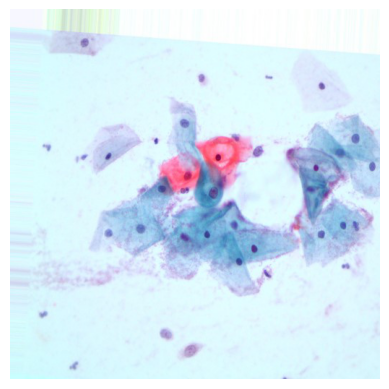

In [ ]:
img = Image.open(pred_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
prediksi_gambar(my_model,pred_path)

## Evaluasi

### Fungction

In [ ]:
def plot_accuracy(train_acc, val_acc, title):
    plt.title(title)
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.ylabel('akurasi')
    plt.xlabel('epoch')
    plt.legend(['train_akurasi', 'validation_akurasi'], loc='best')
    plt.show()

def plot_loss(train_loss, val_loss, title):
    plt.title(title)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

In [ ]:
def cpu_to_nump(training_history, validation_history):
  history = defaultdict(list)
  for i in range (len(training_history['akurasi'])):
    history['train_acc'].append(training_history['akurasi'][i].cpu().numpy())
    history['train_loss'].append(training_history['loss'][i])
    history['val_acc'].append(validation_history['akurasi'][i].cpu().numpy())
    history['val_loss'].append(validation_history['loss'][i])
  return history

In [ ]:
def conf_matrix(y_true, y_pred):
  conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
  fig, ax = plt.subplots(figsize=(7.5, 7.5))
  ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()

In [ ]:
def cm_cr(model):
    y_pred = []
    y_true = []
    model.eval()
    for data, target in tqdm(test_loader):
        y_true = y_true + target.tolist()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        with torch.no_grad():
            output = model(data)
            loss = criterion(output, target)
            _, pred = torch.max(output, 1)
            y_pred = y_pred + pred.tolist()
    print(conf_matrix(y_true,y_pred))
    print(classification_report(y_true,y_pred))

### Hasil

In [ ]:
data_history = cpu_to_nump(my_training_history, my_validation_history)

In [ ]:
plot_accuracy(data_history['train_acc'], data_history['val_acc'], "Pengaruh Nilai Epoch Terhadap nilai Akurasi")

In [ ]:
plot_loss(data_history['train_loss'], data_history['val_loss'], "Pengaruh Nilai Epoch Terhadap nilai Loss")

In [ ]:
cm_cr(my_model_at)

## Waktu Eksekusi

In [ ]:
t = time.time() - start
print('Waktu Eksekusi =  {:.0f}m {:.0f}s'.format(
        t // 60, t % 60))